# 1. Data Preparation

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

def prepare_data(data_dir, img_size=(150, 150), batch_size=32, validation_split=0.2):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split,  # Reserve some images for validation
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Training data generator
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'  # Training data
    )

    # Validation data generator
    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'  # Validation data
    )
    
    return train_generator, validation_generator


2024-10-17 09:44:53.566011: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Model Building Module

In [2]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

def build_cnn_model(input_shape=(150, 150, 3), num_classes=12):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_mobilenetv2_model(input_shape=(150, 150, 3), num_classes=12):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# 3. Training and Evaluation Module

In [3]:
def train_model(model, train_generator, validation_generator, epochs=10):
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size
    )
    return history

def evaluate_model(model, validation_generator):
    results = model.evaluate(validation_generator)
    print(f"Loss: {results[0]}")
    print(f"Accuracy: {results[1]}")
    return results

# 4. Visualization Module

In [7]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

# 5. Main Script

Found 1588 images belonging to 81 classes.
Found 355 images belonging to 81 classes.


/usr/local/Caskroom/miniconda/base/envs/UCB/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/UCB/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.0313 - loss: 4.3034 - val_accuracy: 0.0881 - val_loss: 3.5463
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1250 - loss: 3.6008 - val_accuracy: 0.0000e+00 - val_loss: 4.1214
Epoch 3/10


2024-10-17 09:59:52.422713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/local/Caskroom/miniconda/base/envs/UCB/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-10-17 09:59:52.510798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


49/49 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.1172 - loss: 3.4600 - val_accuracy: 0.1165 - val_loss: 3.1802
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2188 - loss: 2.8089 - val_accuracy: 0.6667 - val_loss: 1.8939
Epoch 5/10


2024-10-17 10:00:47.186478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-17 10:00:47.240311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


49/49 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.1638 - loss: 3.0536 - val_accuracy: 0.2017 - val_loss: 2.7435
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2812 - loss: 2.5979 - val_accuracy: 0.0000e+00 - val_loss: 3.1966
Epoch 7/10


2024-10-17 10:01:44.144712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-17 10:01:44.243194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


49/49 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.1706 - loss: 2.7617 - val_accuracy: 0.1847 - val_loss: 2.5484
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1875 - loss: 2.6324 - val_accuracy: 0.3333 - val_loss: 2.5896
Epoch 9/10


2024-10-17 10:02:40.137676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-17 10:02:40.184483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


49/49 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.2310 - loss: 2.5172 - val_accuracy: 0.2614 - val_loss: 2.2264
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3438 - loss: 1.9893 - val_accuracy: 0.0000e+00 - val_loss: 2.4928


2024-10-17 10:03:35.965168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-17 10:03:36.027499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/var/folders/m9/nwvp3yqj5f76trygypnkypv80000gp/T/ipykernel_39922/3384322687.py:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.1894 - loss: 3.5581 - val_accuracy: 0.4432 - val_loss: 1.7398
Epoch 2/10
 1/49 ━━━━━━━━━━━━━━━━━━━━ 28s 586ms/step - accuracy: 0.3750 - loss: 1.6925

2024-10-17 10:04:43.848178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-17 10:04:43.942815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3750 - loss: 1.6925 - val_accuracy: 1.0000 - val_loss: 0.4604
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 46s 931ms/step - accuracy: 0.4902 - loss: 1.5664 - val_accuracy: 0.6080 - val_loss: 1.0933
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5938 - loss: 0.9419 - val_accuracy: 0.6667 - val_loss: 1.7764
Epoch 5/10


2024-10-17 10:05:30.613107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-17 10:05:30.700757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


49/49 ━━━━━━━━━━━━━━━━━━━━ 46s 929ms/step - accuracy: 0.6135 - loss: 1.1370 - val_accuracy: 0.6591 - val_loss: 0.8935
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 0.8884 - val_accuracy: 1.0000 - val_loss: 0.3038
Epoch 7/10


2024-10-17 10:06:17.288258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-17 10:06:17.354761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


49/49 ━━━━━━━━━━━━━━━━━━━━ 44s 883ms/step - accuracy: 0.6664 - loss: 0.9299 - val_accuracy: 0.7216 - val_loss: 0.8165
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6562 - loss: 1.0342 - val_accuracy: 1.0000 - val_loss: 0.0826
Epoch 9/10


2024-10-17 10:07:01.494505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-17 10:07:01.566109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 856ms/step - accuracy: 0.7592 - loss: 0.7252 - val_accuracy: 0.7528 - val_loss: 0.7346
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.3702 - val_accuracy: 1.0000 - val_loss: 0.0720


2024-10-17 10:07:44.257682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-17 10:07:44.319791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 528ms/step - accuracy: 0.2535 - loss: 2.1985
Loss: 2.231290817260742
Accuracy: 0.23943662643432617
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 757ms/step - accuracy: 0.7465 - loss: 0.6622
Loss: 0.6630392670631409
Accuracy: 0.7492957711219788


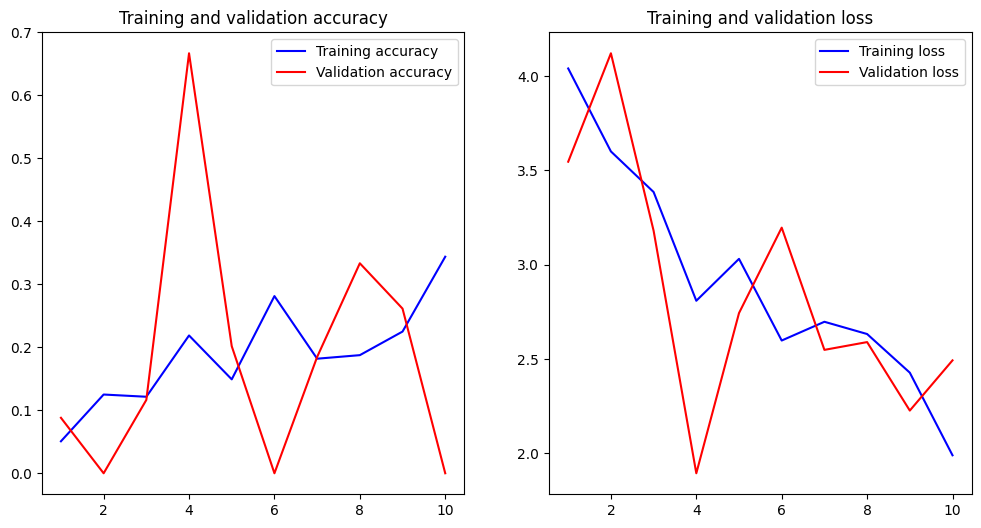

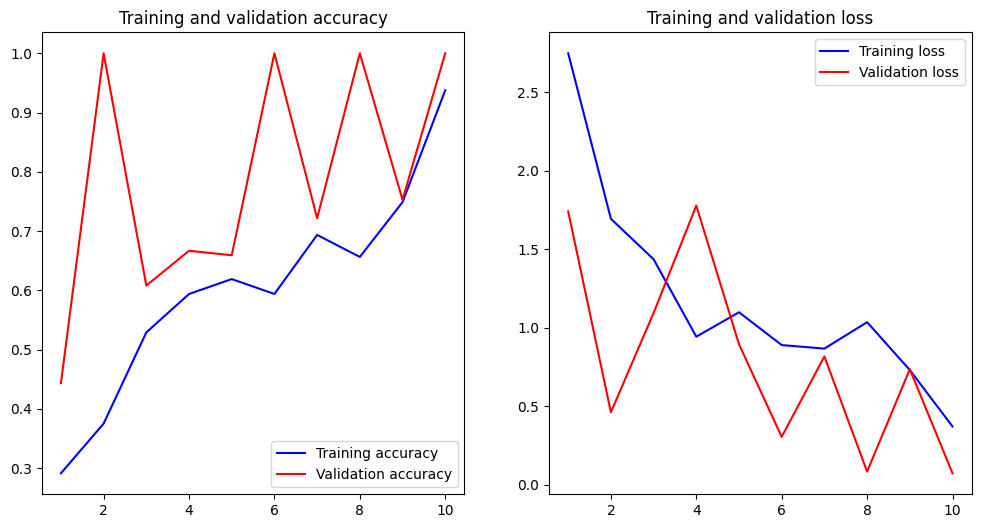

In [8]:
if __name__ == '__main__':
    data_dir = "flattened_images"
    
    # Prepare data
    train_generator, validation_generator = prepare_data(data_dir)

    # Build and train CNN
    cnn_model = build_cnn_model(num_classes=train_generator.num_classes)
    cnn_history = train_model(cnn_model, train_generator, validation_generator, epochs=10)

    # Build and train MobileNetV2
    mobilenetv2_model = build_mobilenetv2_model(num_classes=train_generator.num_classes)
    mobilenetv2_history = train_model(mobilenetv2_model, train_generator, validation_generator, epochs=10)

    # Evaluate models
    evaluate_model(cnn_model, validation_generator)
    evaluate_model(mobilenetv2_model, validation_generator)

    # Plot training history
    plot_training_history(cnn_history)
    plot_training_history(mobilenetv2_history)
